In [541]:
import numpy as np
import pandas as pd
import math
import sys
import matplotlib.pyplot as plt
import random

In [460]:
def find_best_split(candidate_splits):
    
    best_split = max(candidate_splits, key = lambda x: (x[4], x[3] != 0.0))
    if best_split[4] == -sys.float_info.max:
        raise Exception("Somehow split info was not 0.0 but gain ratio was still -sys.float_info.max!")
    return best_split

In [461]:
def logbase2(n):
    if n != 0:
        return math.log(n, 2)
    else:
        return -sys.float_info.max

In [462]:
def calculate_entropy(a, b):
    
    total = a + b
    
    prob_a = a/total
    prob_b = b/total
    
    entropy = - (prob_a * logbase2(prob_a)) - (prob_b * logbase2(prob_b))
    
    return entropy

In [463]:
def calculate_info_gain_and_split_info(total_number_of_zeros, total_number_of_ones, number_of_zeros_left, number_of_ones_left, number_of_zeros_right, number_of_ones_right):

    entropy_y = calculate_entropy(total_number_of_zeros, total_number_of_ones)
    entropy_y_left = calculate_entropy(number_of_zeros_left, number_of_ones_left)
    entropy_y_right = calculate_entropy(number_of_zeros_right, number_of_ones_right)

    total_zeros_and_ones_left = number_of_zeros_left + number_of_ones_left
    total_zeros_and_ones_right = number_of_zeros_right + number_of_ones_right

    weight_left = total_zeros_and_ones_left / (total_number_of_zeros + total_number_of_ones)
    weight_right = total_zeros_and_ones_right / (total_number_of_zeros + total_number_of_ones)

    info_gain = entropy_y - (weight_left * entropy_y_left) - (weight_right * entropy_y_right)
    split_info = calculate_entropy(total_zeros_and_ones_left, total_zeros_and_ones_right)

    return info_gain, split_info

In [464]:
def determine_candidate_splits(df):
    # candidate splits is a nested list containing [1, 0.04] i.e. 1 (for x1) and 0.04 for xj's value
    candidate_splits = []
    df_x1 = df.sort_values('x1')
    df_x1 = df_x1.reset_index(drop=True)
    df_x2 = df.sort_values('x2')
    df_x2 = df_x2.reset_index(drop=True)

    # total_number_of_zeros = df['y'].value_counts()[0]
    # total_number_of_ones = df['y'].value_counts()[1]
    total_number_of_zeros = np.sum(df['y'] == 0)
    total_number_of_ones = np.sum(df['y'] == 1)
    
    for i in range(1, len(df)):
        
        if df_x1['y'][i] != df_x1['y'][i - 1] and df_x1['x1'][i] != df_x1['x1'][i - 1]:
            # y has changed
            number_of_zeros_left = np.sum(df_x1['y'].iloc[:i] == 0)
            number_of_ones_left = np.sum(df_x1['y'].iloc[:i] == 1)
            number_of_zeros_right = np.sum(df_x1['y'].iloc[i:] == 0)
            number_of_ones_right = np.sum(df_x1['y'].iloc[i:] == 1)
            # candidate_splits.append([1, df_x1['x1'][i], total_number_of_zeros, total_number_of_ones, number_of_zeros_left, number_of_ones_left, number_of_zeros_right, number_of_ones_right])
            info_gain, split_info = calculate_info_gain_and_split_info(total_number_of_zeros, total_number_of_ones, number_of_zeros_left, number_of_ones_left, number_of_zeros_right, number_of_ones_right)
            if split_info != 0.0:
                gain_ratio = info_gain / split_info
                candidate_splits.append([1, df_x1['x1'][i], info_gain, split_info, gain_ratio])
            else:
                gain_ratio = -sys.float_info.max
                candidate_splits.append([1, df_x1['x1'][i], info_gain, split_info, gain_ratio])
            
        if df_x2['y'][i] != df_x2['y'][i - 1] and df_x2['x2'][i] != df_x2['x2'][i - 1]:
            # y has changed
            number_of_zeros_left = np.sum(df_x2['y'].iloc[:i] == 0)
            number_of_ones_left = np.sum(df_x2['y'].iloc[:i] == 1)
            number_of_zeros_right = np.sum(df_x2['y'].iloc[i:] == 0)
            number_of_ones_right = np.sum(df_x2['y'].iloc[i:] == 1)
            # candidate_splits.append([2, df_x2['x2'][i], total_number_of_zeros, total_number_of_ones, number_of_zeros_left, number_of_ones_left, number_of_zeros_right, number_of_ones_right])
            info_gain, split_info = calculate_info_gain_and_split_info(total_number_of_zeros, total_number_of_ones, number_of_zeros_left, number_of_ones_left, number_of_zeros_right, number_of_ones_right)
            if split_info != 0.0:
                gain_ratio = info_gain / split_info
                candidate_splits.append([2, df_x2['x2'][i], info_gain, split_info, gain_ratio])
            else:
                gain_ratio = -sys.float_info.max
                candidate_splits.append([2, df_x2['x2'][i], info_gain, split_info, gain_ratio])

    # We can have empty candidate splits if the df has 0 or 1 rows, or if all rows in df have same y,
    # or if none of the splits have non-0 split_info
    return candidate_splits

In [465]:
def stopping_criteria_satisfied(len_df, set_of_candidate_splits):
    # node is empty, or
    # all splits have zero gain ratio, or
    # all splits have zero split information
    if len_df == 0:
        return True
        
    all_splits_have_zero_gain_ratio = True
    
    for candidate_split in set_of_candidate_splits:
        if len(candidate_split) >= 5 and candidate_split[3] != 0.0 and candidate_split[4] != 0.0:
            all_splits_have_zero_gain_ratio = False

    if all_splits_have_zero_gain_ratio:
        return True
    
    return False

In [466]:
class Node:
    # double check
    def __init__(self, feature_number, value, info_gain, split_info, gain_ratio, candidate_splits, height, left_child, right_child):
        self.feature_number = feature_number
        self.value = value
        self.info_gain = info_gain
        self.split_info = split_info
        self.gain_ratio = gain_ratio
        self.candidate_splits = candidate_splits
        self.height = height
        self.left_child = left_child
        self.right_child = right_child

In [467]:
def get_df_subsets(df, feature_number, feature_value):
    # print(f"Feature number: {feature_number}, and feature_value: {feature_value}")
    if feature_number == 1:
        df_sorted_on_x1 = df.sort_values('x1')
        df_sorted_on_x1 = df_sorted_on_x1.reset_index(drop=True)
        # print(f"df_sorted_on_x1: {df_sorted_on_x1}")
        
        index_of_x1 = -1
        
        for i in range(0, len(df)):
            if df_sorted_on_x1['x1'][i] == feature_value:
                index_of_x1 = i
                # print(f"index_of_x1: {index_of_x1}")
                break
            
        left_df_subset = df_sorted_on_x1.iloc[index_of_x1:].copy().reset_index(drop=True)
        right_df_subset = df_sorted_on_x1.iloc[:index_of_x1].copy().reset_index(drop=True)
        
        return left_df_subset, right_df_subset
    else:
        df_sorted_on_x2 = df.sort_values('x2')
        df_sorted_on_x2 = df_sorted_on_x2.reset_index(drop=True)
        
        index_of_x2 = -1

        for i in range(0, len(df)):
            if df_sorted_on_x2['x2'][i] == feature_value:
                index_of_x2 = i
                break

        left_df_subset = df_sorted_on_x2.iloc[index_of_x2:].copy().reset_index(drop=True)
        right_df_subset = df_sorted_on_x2.iloc[:index_of_x2].copy().reset_index(drop=True)
        
        return left_df_subset, right_df_subset

In [468]:
def determine_class_label(df):
    if len(df) == 0:
        return 1
    number_of_zeros = np.sum(df['y'] == 0)
    number_of_ones = np.sum(df['y'] == 1)
    if number_of_zeros > number_of_ones:
        return 0
    else:
        return 1

In [469]:
def make_subtree(df, height):
    
    candidate_splits = determine_candidate_splits(df)
    
    if stopping_criteria_satisfied(len(df), candidate_splits):
        
        # Make leaf node, and assign a class label to it
        class_label = determine_class_label(df)
        leaf_node = Node(None, class_label, None, None, None, candidate_splits, height, None, None)
        
        return leaf_node
        
    else:
        
        # Make internal node, assign split condition and children
        best_split = find_best_split(candidate_splits)

        feature_number = best_split[0]
        feature_value = best_split[1]
        info_gain = best_split[2]
        split_info = best_split[3]
        gain_ratio = best_split[4]
        
        left_df_subset, right_df_subset = get_df_subsets(df, feature_number, feature_value)

        # print("left_df_subset: ", left_df_subset)
        # print("right_df_subset: ", right_df_subset)
        
        left_child = make_subtree(left_df_subset, height + 1)
        right_child = make_subtree(right_df_subset, height + 1)
        
        internal_node = Node(feature_number, feature_value, info_gain, split_info, gain_ratio, candidate_splits, height, left_child, right_child)
        
        return internal_node

In [470]:
def print_preorder_traversal(node):
    if node:
        if node.feature_number != None:
            print("    " * node.height + "x" + str(node.feature_number) + " >= " + str(node.value))
        else:
            print("    " * node.height + "y = " + str(node.value))
        
        print_preorder_traversal(node.left_child)
        print_preorder_traversal(node.right_child)

In [471]:
def print_candidate_splits_details(node):
    if node:
        if node.candidate_splits:
            for candidate_split in node.candidate_splits:
                if candidate_split[3] != 0.0:
                    print("Candidate cut: x" + str(candidate_split[0]) + " >= " + str(candidate_split[1]) + ", Information gain ratio = " + str(candidate_split[4]))
                else:
                    print("Candidate cut: x" + str(candidate_split[0]) + " >= " + str(candidate_split[1]) + ", Mutual information = " + str(candidate_split[2]))

In [506]:
def calculate_number_of_nodes(node):
    if node:
        if node.feature_number != None:
            return calculate_number_of_nodes(node.left_child) + calculate_number_of_nodes(node.right_child)
        else:
            return 1
    else:
        return 0

In [504]:
def predict_class_label_using_tree(node, x1_value, x2_value):
    if node:
        if node.feature_number == 1:
            if x1_value >= node.value:
                return predict_class_label_using_tree(node.left_child, x1_value, x2_value)
            else:
                return predict_class_label_using_tree(node.right_child, x1_value, x2_value)
        elif node.feature_number == 2:
            if x2_value >= node.value1_value, x2_value)
            else:
                return predict_class_label_using_tree(node.right_child, x1_value, x2_value)
        else:
            return node.value:
                return predict_class_label_using_tree(node.left_child, x

In [507]:
def calculate_error_percent(node, testing_df):
    
    incorrect_predictions = 0
    
    for i in range(0, len(testing_df)):
        
        predicted_label = predict_class_label_using_tree(node, testing_df['x1'][i], testing_df['x2'][i])
        
        if predicted_label != testing_df['y'][i]:
            incorrect_predictions += 1
            
    error_percent = (incorrect_predictions / len(testing_df)) * 100
    
    return error_percent

In [509]:
# Q1
file_name = 'q1.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()
root_node = make_subtree(df, 0)
print_preorder_traversal(root_node)

y = 1


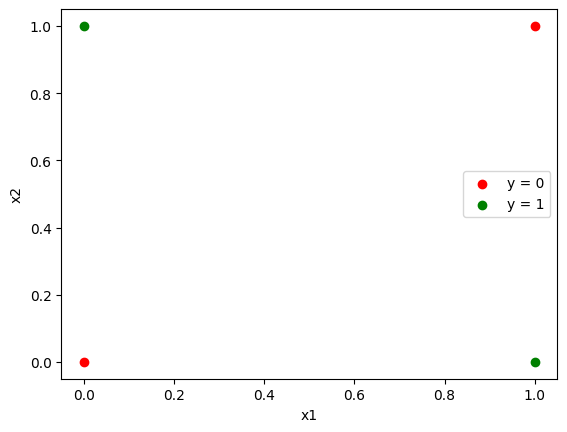

y = 1


In [550]:
# Q2
file_name = 'q2.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()

df_zeros = df[df['y'] == 0]
df_ones = df[df['y'] == 1]

plt.scatter(df_zeros['x1'], df_zeros['x2'], marker = 'o', color = 'Red')
plt.scatter(df_ones['x1'], df_ones['x2'], marker = 'o', color = 'Green')

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend(["y = 0", "y = 1"])

plt.show()

root_node = make_subtree(df, 0)
print_preorder_traversal(root_node)

In [551]:
# Q3
file_name = 'Druns.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()
root_node = make_subtree(df, 0)
# print_preorder_traversal(root_node)
print_candidate_splits_details(root_node)

Candidate cut: x2 >= -1, Information gain ratio = 0.10051807676021852
Candidate cut: x2 >= 0, Information gain ratio = 0.055953759631263686
Candidate cut: x2 >= 6, Information gain ratio = 0.2360996061436081
Candidate cut: x2 >= 7, Information gain ratio = 0.05595375963126377
Candidate cut: x1 >= 0.1, Information gain ratio = 0.10051807676021852
Candidate cut: x2 >= 8, Information gain ratio = 0.43015691613098095


In [552]:
# Q4
file_name = 'D3leaves.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()
root_node = make_subtree(df, 0)
print_preorder_traversal(root_node)

x2 >= 2
    y = 1
    x1 >= 10
        y = 1
        y = 0


In [602]:
# Q5
file_name = 'D1.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()
root_node_d1 = make_subtree(df, 0)
print("Decision Tree for D1.txt:\n")
print_preorder_traversal(root_node_d1)

file_name = 'D2.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()
root_node_d2 = make_subtree(df, 0)
print("\n\nDecision Tree for D2.txt:\n")
print_preorder_traversal(root_node_d2)

Decision Tree for D1.txt:

x2 >= 0.201829
    y = 1
    y = 0


Decision Tree for D2.txt:

x1 >= 0.533076
    x2 >= 0.228007
        x2 >= 0.424906
            y = 1
            x1 >= 0.708127
                y = 1
                x2 >= 0.32625
                    x1 >= 0.595471
                        x1 >= 0.646007
                            y = 1
                            x2 >= 0.403494
                                y = 1
                                y = 0
                        y = 0
                    y = 0
        x1 >= 0.887224
            x2 >= 0.037708
                x2 >= 0.082895
                    y = 1
                    x1 >= 0.960783
                        y = 1
                        y = 0
                y = 0
            x1 >= 0.850316
                x2 >= 0.169053
                    y = 1
                    y = 0
                y = 0
    x2 >= 0.88635
        x1 >= 0.041245
            x1 >= 0.104043
                y = 1
                x2 >= 0.96

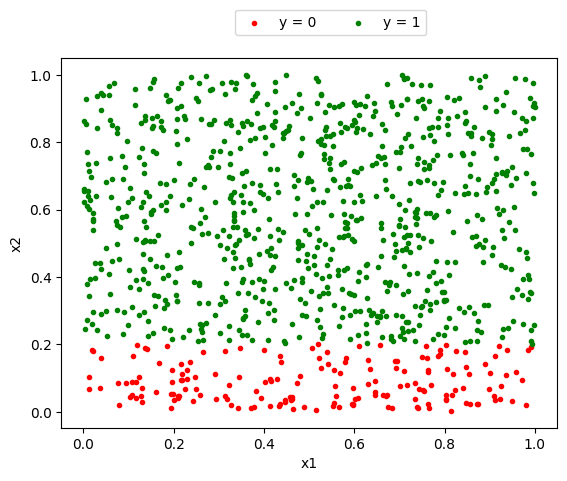

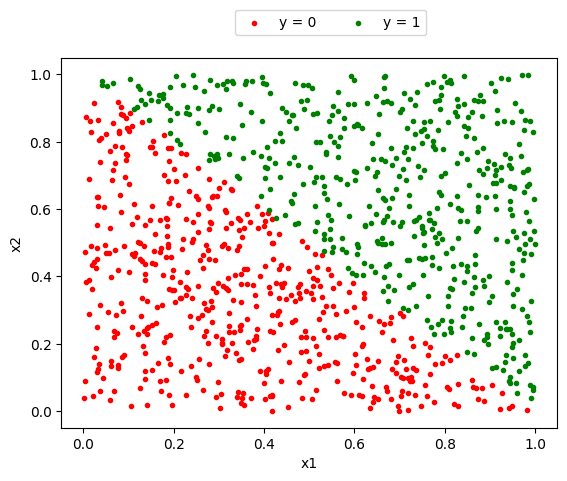

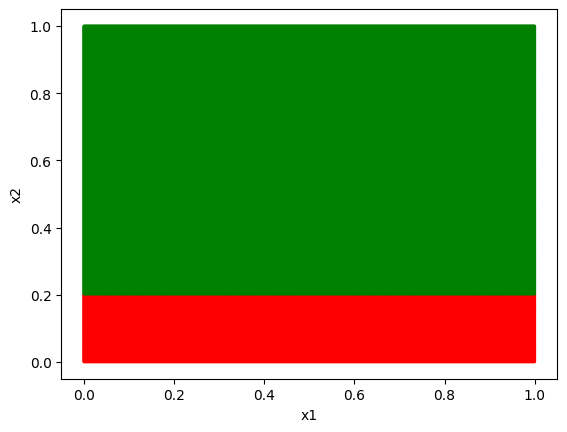

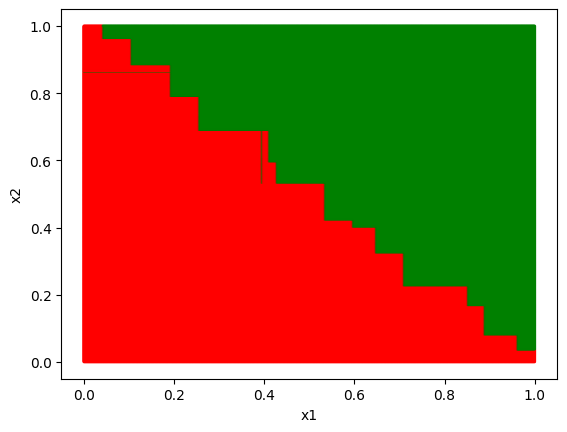

In [607]:
# Q6
file_name = 'D1.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()

df_zeros = df[df['y'] == 0]
df_ones = df[df['y'] == 1]

plt.scatter(df_zeros['x1'], df_zeros['x2'], marker = '.', color = 'Red', label = 'y = 0')
plt.scatter(df_ones['x1'], df_ones['x2'], marker = '.', color = 'Green', label = 'y = 1')

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)

plt.show()

file_name = 'D2.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()

df_zeros = df[df['y'] == 0]
df_ones = df[df['y'] == 1]

plt.scatter(df_zeros['x1'], df_zeros['x2'], marker = '.', color = 'Red', label = 'y = 0')
plt.scatter(df_ones['x1'], df_ones['x2'], marker = '.', color = 'Green', label = 'y = 1')

plt.xlabel('x1')
plt.ylabel('x2')

plt.legend(bbox_to_anchor =(0.75, 1.15), ncol = 2)

plt.show()

x1_range = np.arange(0.0, 1.001, 0.001)
x2_range = np.arange(0.0, 1.001, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_d1, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

# plt.figure(figsize=(8, 8))
plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

x1_range = np.arange(0.0, 1.001, 0.001)
x2_range = np.arange(0.0, 1.001, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_d2, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

# plt.figure(figsize=(8, 8))
plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

n	number of nodes		error percent
32 	 5 			 17.809734513274336 %
128 	 13 			 9.513274336283185 %
512 	 29 			 5.530973451327434 %
2048 	 66 			 3.9269911504424777 %
8192 	 130 			 2.0464601769911503 %


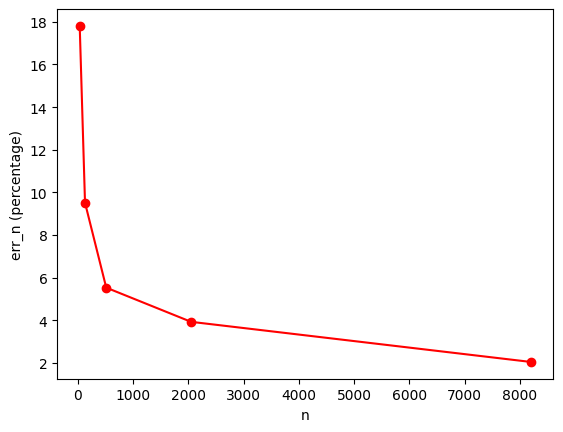

In [557]:
# Q7
file_name = 'Dbig.txt'
df = pd.read_csv(file_name, delim_whitespace=True, header = None)
df.columns = ['x1', 'x2', 'y']
df.reset_index()

indices_randomized = np.random.permutation(10000)
df_randomized = df.iloc[indices_randomized].reset_index(drop = True)

training_df_8192 = df_randomized.iloc[:8192].copy().reset_index(drop=True)
testing_df = df_randomized.iloc[8192:].copy().reset_index(drop=True)

training_df_32 = df_randomized.iloc[:32].copy().reset_index(drop=True)
training_df_128 = df_randomized.iloc[:128].copy().reset_index(drop=True)
training_df_512 = df_randomized.iloc[:512].copy().reset_index(drop=True)
training_df_2048 = df_randomized.iloc[:2048].copy().reset_index(drop=True)

root_node_32 = make_subtree(training_df_32, 0)
root_node_128 = make_subtree(training_df_128, 0)
root_node_512 = make_subtree(training_df_512, 0)
root_node_2048 = make_subtree(training_df_2048, 0)
root_node_8192 = make_subtree(training_df_8192, 0)

list_of_number_of_nodes = []

list_of_number_of_nodes.append(calculate_number_of_nodes(root_node_32))
list_of_number_of_nodes.append(calculate_number_of_nodes(root_node_128))
list_of_number_of_nodes.append(calculate_number_of_nodes(root_node_512))
list_of_number_of_nodes.append(calculate_number_of_nodes(root_node_2048))
list_of_number_of_nodes.append(calculate_number_of_nodes(root_node_8192))

list_of_error_percent = []

list_of_error_percent.append(calculate_error_percent(root_node_32, testing_df))
list_of_error_percent.append(calculate_error_percent(root_node_128, testing_df))
list_of_error_percent.append(calculate_error_percent(root_node_512, testing_df))
list_of_error_percent.append(calculate_error_percent(root_node_2048, testing_df))
list_of_error_percent.append(calculate_error_percent(root_node_8192, testing_df))

list_of_n = [32, 128, 512, 2048, 8192]

print("n\tnumber of nodes\t\terror percent")
for i in range (0, 5):
    print(list_of_n[i], "\t", list_of_number_of_nodes[i], "\t\t\t", list_of_error_percent[i], "%")

plt.plot(list_of_n, list_of_error_percent, marker = 'o', color = "Red")
plt.xlabel('n')
plt.ylabel('err_n (percentage)')
plt.show()

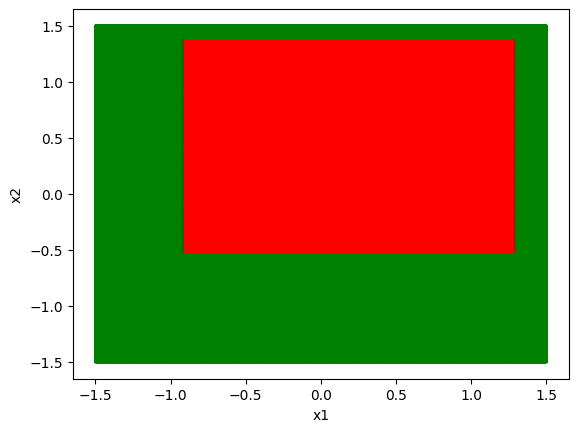

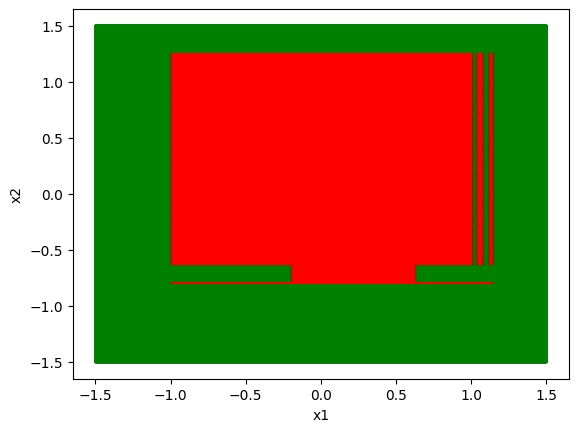

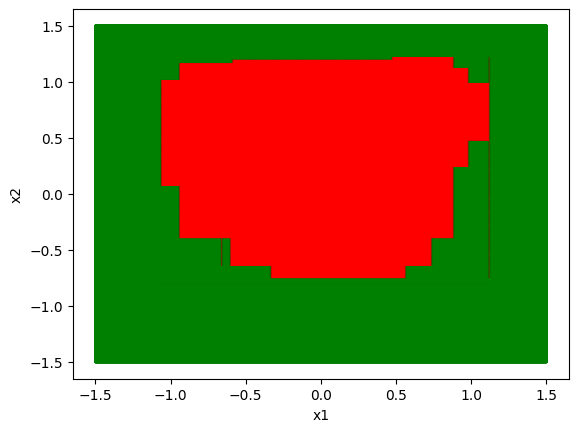

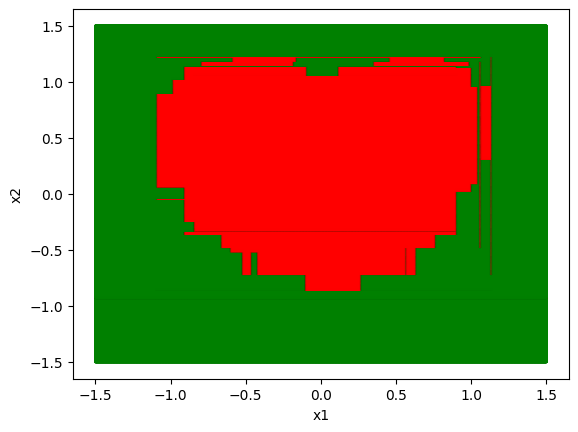

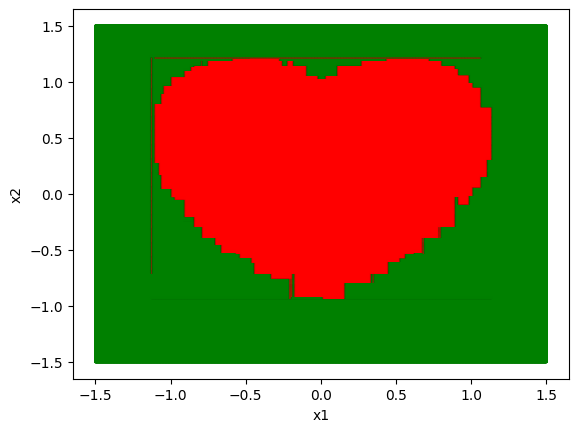

In [609]:
x1_range = np.arange(-1.5, 1.501, 0.001)
x2_range = np.arange(-1.5, 1.501, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_32, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

x1_range = np.arange(-1.5, 1.501, 0.001)
x2_range = np.arange(-1.5, 1.501, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_128, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

x1_range = np.arange(-1.5, 1.501, 0.001)
x2_range = np.arange(-1.5, 1.501, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_512, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

x1_range = np.arange(-1.5, 1.501, 0.001)
x2_range = np.arange(-1.5, 1.501, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_2048, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

x1_range = np.arange(-1.5, 1.501, 0.001)
x2_range = np.arange(-1.5, 1.501, 0.001)

class_labels = []
point_colors = []
x1_grid, x2_grid = np.meshgrid(x1_range, x2_range)
for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel()):
    class_label = predict_class_label_using_tree(root_node_8192, x1, x2)
    class_labels.append(class_label)
    point_colors.append('red' if class_label == 0 else 'green')

class_labels = np.array(class_labels).reshape(x1_grid.shape)

plt.scatter(x1_grid, x2_grid, c = point_colors, s = 1, alpha = 0.5)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

n	number of nodes	error percent
32 	 9 			 11.946902654867253 %
128 	 15 			 8.849557522123897 %
512 	 47 			 7.300884955752207 %
2048 	 99 			 2.1017699115044253 %
8192 	 229 			 1.603982300884954 %


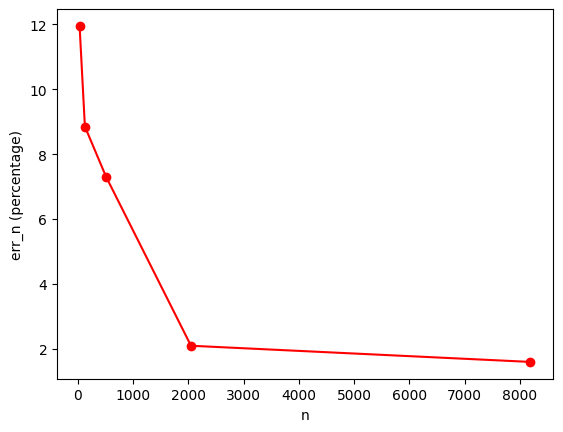

In [540]:
# Q3

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

list_of_number_of_nodes = []
list_of_error_percent = []

decision_tree = DecisionTreeClassifier(criterion = 'entropy', splitter = 'best')

decision_tree.fit(training_df_32[['x1', 'x2']], training_df_32['y'])
list_of_number_of_nodes.append(decision_tree.tree_.node_count)
predicted_class_labels = decision_tree.predict(testing_df[['x1', 'x2']])
list_of_error_percent.append((1 - accuracy_score(testing_df['y'], predicted_class_labels)) * 100)

decision_tree.fit(training_df_128[['x1', 'x2']], training_df_128['y'])
list_of_number_of_nodes.append(decision_tree.tree_.node_count)
predicted_class_labels = decision_tree.predict(testing_df[['x1', 'x2']])
list_of_error_percent.append((1 - accuracy_score(testing_df['y'], predicted_class_labels)) * 100)

decision_tree.fit(training_df_512[['x1', 'x2']], training_df_512['y'])
list_of_number_of_nodes.append(decision_tree.tree_.node_count)
predicted_class_labels = decision_tree.predict(testing_df[['x1', 'x2']])
list_of_error_percent.append((1 - accuracy_score(testing_df['y'], predicted_class_labels)) * 100)

decision_tree.fit(training_df_2048[['x1', 'x2']], training_df_2048['y'])
list_of_number_of_nodes.append(decision_tree.tree_.node_count)
predicted_class_labels = decision_tree.predict(testing_df[['x1', 'x2']])
list_of_error_percent.append((1 - accuracy_score(testing_df['y'], predicted_class_labels)) * 100)

decision_tree.fit(training_df_8192[['x1', 'x2']], training_df_8192['y'])
list_of_number_of_nodes.append(decision_tree.tree_.node_count)
predicted_class_labels = decision_tree.predict(testing_df[['x1', 'x2']])
list_of_error_percent.append((1 - accuracy_score(testing_df['y'], predicted_class_labels)) * 100)

list_of_n = [32, 128, 512, 2048, 8192]

print("n\tnumber of nodes\terror percent")
for i in range (0, 5):
    print(list_of_n[i], "\t", list_of_number_of_nodes[i], "\t\t\t", list_of_error_percent[i], "%")

plt.plot(list_of_n, list_of_error_percent, marker = 'o', color = "Red")
plt.xlabel('n')
plt.ylabel('err_n (percentage)')
plt.show()

In [581]:
def calculate_log_mean_squared_error(test_values, predicted_values):
    if len(test_values) != len(predicted_values):
        raise Exception(f"Number of elements in test and predicted values are not same: {len(test_values)}, {len(predicted_values)}")
    squared_error = 0.0
    for i in range(0, len(test_values)):
        squared_error += ((test_values[i] - predicted_values[i]) ** 2)
    mean_squared_error = squared_error / len(test_values)
    log_mean_squared_error = logbase2(mean_squared_error)
    return log_mean_squared_error

In [601]:
# Q4

from scipy.interpolate import lagrange

x_train_values = []
y_train_values = []
y_train_predicted_values = []

for i in range(0, 100):
    x_train_values.append(random.uniform(-10.0, 10.0))
for x in x_train_values:
    y_train_values.append(math.sin(x))

model = lagrange(x_train_values, y_train_values)

for x in x_train_values:
    y_train_predicted_values.append(model(x))

x_test_values = []
y_test_values = []

for i in range(0, 100):
    x_test_values.append(random.uniform(-10.0, 10.0))
for x in x_test_values:
    y_test_values.append(math.sin(x))

y_predicted_values = []

for x in x_test_values:
    y_predicted_values.append(model(x))

print("Log mean squared error of model on training data: ", calculate_log_mean_squared_error(y_train_values, y_train_predicted_values))
print("Log mean squared error of model on testing data: ", calculate_log_mean_squared_error(y_test_values, y_predicted_values))

x_train_values_with_noise = []
y_train_values_with_noise = []
y_train_predicted_values = []
list_of_epsilons = [0.00000001, 0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]

for epsilon in list_of_epsilons:
    x_train_values_with_noise.clear()
    y_train_values_with_noise.clear()
    y_train_predicted_values.clear()
    y_predicted_values.clear()
    gaussian_noise = np.random.normal(0, epsilon, 100)
    for i in range(0, 100):
        x_train_values_with_noise.append(x_train_values[i] + gaussian_noise[i])
    for x in x_train_values_with_noise:
        y_train_values_with_noise.append(math.sin(x))
    model = lagrange(x_train_values_with_noise, y_train_values_with_noise)
    for x in x_train_values_with_noise:
        y_train_predicted_values.append(model(x))
    for x in x_test_values:
        y_predicted_values.append(model(x))
    
    print("With epsilon ", epsilon, ", log mean squared error of model on training data: ", calculate_log_mean_squared_error(y_test_values, y_train_predicted_values))
    print("With epsilon ", epsilon, ", log mean squared error of model on testing data: ", calculate_log_mean_squared_error(y_test_values, y_predicted_values))

Log mean squared error of model on training data:  219.61727938068586
Log mean squared error of model on testing data:  215.35341144140435
With epsilon  1e-08 , log mean squared error of model on training data:  221.30026070354174
With epsilon  1e-08 , log mean squared error of model on testing data:  216.34065893718218
With epsilon  1e-07 , log mean squared error of model on training data:  216.51165740175495
With epsilon  1e-07 , log mean squared error of model on testing data:  214.04748293122816
With epsilon  1e-06 , log mean squared error of model on training data:  217.02319859073728
With epsilon  1e-06 , log mean squared error of model on testing data:  215.34989452632942
With epsilon  1e-05 , log mean squared error of model on training data:  222.62822880634445
With epsilon  1e-05 , log mean squared error of model on testing data:  217.45506310939055
With epsilon  0.0001 , log mean squared error of model on training data:  224.65641899890545
With epsilon  0.0001 , log mean squa